In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import dreye

In [2]:
domain = np.arange(300, 700, 1)
filters = norm.pdf(domain, loc=np.array([440, 565])[:, None], scale=55)
filters = filters / np.max(filters, axis=-1, keepdims=True)

In [3]:
est = dreye.ReceptorEstimator(filters, domain=domain)

<AxesSubplot:>

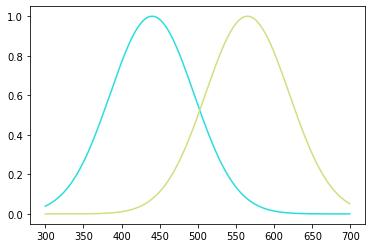

In [4]:
est.filter_plot()

In [5]:
sources = norm.pdf(domain, loc=np.array([410, 480, 530])[:, None], scale=20)
sources = sources / np.sum(sources, axis=-1, keepdims=True)

In [6]:
est.register_system(sources, lb=0, ub=100)

<AxesSubplot:>

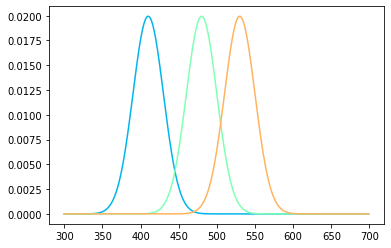

In [7]:
est.sources_plot()

In [8]:
est.register_system_adaptation([5, 4, 9])

In [9]:
est.K

array([0.10320861, 0.11732678])

In [10]:
B = est.sample_in_hull(100, seed=10, engine='Halton')

In [11]:
est.in_hull(B).all()

True

In [12]:
est.register_targets(B)

In [13]:
mins, maxs = est.range_of_solutions(B)

In [14]:
mins[0], maxs[0]

(array([ 0.        ,  0.        , 15.18888813]),
 array([37.20707695, 48.51717479, 34.0616108 ]))

In [15]:
X, Bhat = est.fit(B)

In [16]:
np.allclose(B, Bhat)

True

In [17]:
X, scales, Bhat = est.fit_adaptive(B)

In [18]:
np.allclose(B, Bhat)

True

In [19]:
X, P, Bhat = est.fit_decomposition(B, n_layers=2)

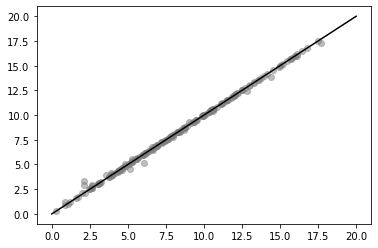

In [20]:
plt.scatter(B, Bhat, color='gray', alpha=0.5)
plt.plot([0, 20], [0, 20], color='black')

In [21]:
X, Bhat = est.fit_underdetermined(B, 'min')

In [22]:
np.allclose(B, Bhat)

True

In [23]:
X, Bhat, Bvar = est.minimize_variance(B)

/Users/gucky92/opt/anaconda3/envs/dreye/lib/python3.9/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


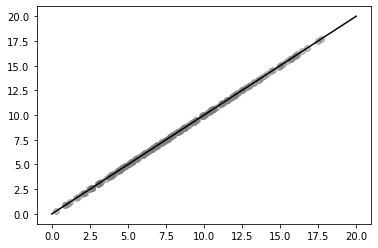

In [24]:
plt.scatter(B, Bhat, color='gray', alpha=0.5)
plt.plot([0, 20], [0, 20], color='black')

In [29]:
est.compute_gamut(metric='volume')

0.7191505057452802